# Домашнее задание по теме "Feature Selection"

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно** <br>
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC <br>
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной <br>
**О какой дисперсии идёт речь? Здесь задача классификации, всего 2 значения у таргетной переменной**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('kobe.csv')

In [3]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
# целевая переменная
target = 'shot_made_flag'

### Первичный анализ данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

Наблюдаем, что пропущенных значений (за исключением специально выкинутых 5000 значений таргетной переменной) нет. Это избавляет нас от работы с пропусками.

In [6]:
data.describe(include=['number'])

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


In [7]:
data.describe(include=['object'])

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,20,2,6,7,5,1,1559,74,33
top,Jump Shot,Jump Shot,2005-06,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,18880,23485,2318,24271,13455,12625,9398,30697,50,1020,1978


Посмотрим корреляцию признаков.

In [8]:
corr = data.corr()

<AxesSubplot:>

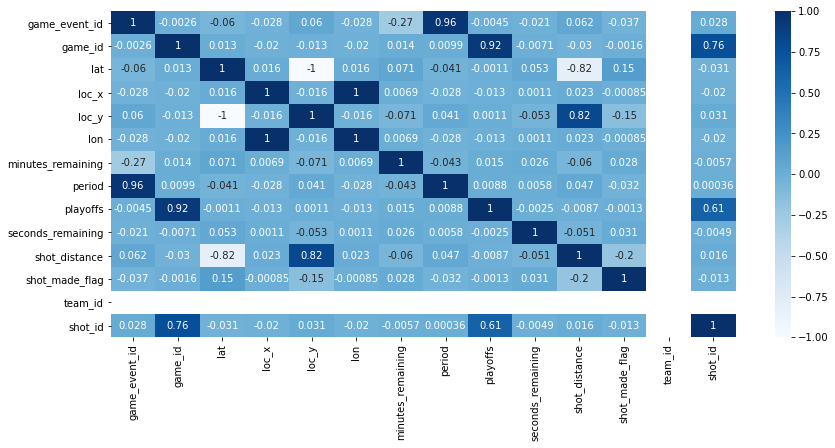

In [9]:
plt.figure(figsize=[14,6])
sns.heatmap(corr, cmap='Blues', annot=True)

Ни один из признаков не коррелирует достаточно сильно с целевой переменной shot_made_flag. Наблюдается, однако, сильная корреляция признаков period и game_event_id, game_id и playoffs, lat и loc_y, lon и loc_x, lat и shot_distance, loc_y и shot_distance. Попробуем исключить некоторые из этих признаков перед обучением. Также добавляем в этот список целевую переменную.

In [10]:
columns_to_exclude = ['game_event_id', 'game_id', 'loc_x', 'loc_y', target]

У нас нет правильных ответов для пропущенных значений, поэтому, чтобы оценить точность работы моделей, возьмём ту часть датасета, для которой у нас есть правильные значения целевой переменной, и разобьём её на тренировочную и тестовую выборки.

In [11]:
# исключаем строки с пропущенными значениями
data = data.dropna()
# запоминаем целевую переменную
y = data[target]
# исключаем из датасета лишние столбцы
X = data.drop(columns_to_exclude, axis=1)

Делим признаки на категориальные и численные.

In [12]:
# Находим категориальные признаки
cat_feat = list(X.dtypes[data.dtypes == object].index) 

# Добавляем вручную некоторые признаки с типом integer
cat_feat.extend(['playoffs', 'period', 'team_id'])

cont_feat = [f for f in X if f not in (cat_feat + ['shot_id'])]

Проверим столбцы, содержащие в себе численные признаки, на выбросы.

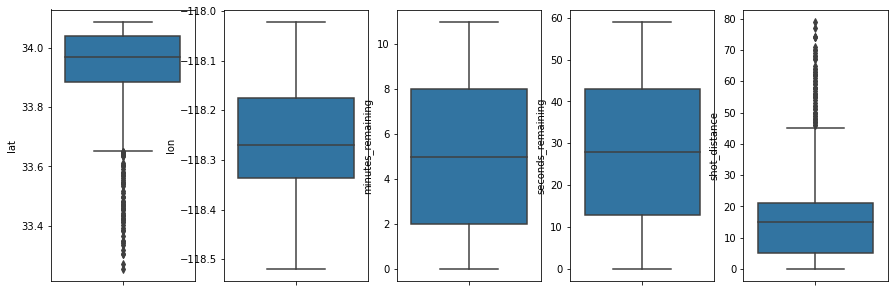

In [13]:
fig, axs = plt.subplots(ncols=len(cont_feat), figsize=(15,5))
for i in range(len(cont_feat)):
    sns.boxplot(y=X[cont_feat[i]], ax=axs[i])

Значений, явно выбивающихся из общей картины и которые можно отнести к выбросам, не наблюдаем.

In [14]:
# Создаём дамми-переменные для категориальных признаков
dummy = pd.get_dummies(X[cat_feat], columns=cat_feat)

# Объединяем с численными столбцами для получения готового для использования датасета
X = pd.concat([data[cont_feat], dummy], axis=1)

### Создание и обучение моделей

In [17]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import auc, roc_curve, roc_auc_score

In [15]:
def show_auc(y, y_pred, plot_label='', prin=True):    
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend()
    return auc_val

In [16]:
# Разбиваем данные
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
clf = make_pipeline(StandardScaler(), linear_model.SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [19]:
clf_lasso = make_pipeline(StandardScaler(), linear_model.Lasso())
clf_lasso.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('lasso', Lasso())])

In [20]:
clf_ridge = make_pipeline(StandardScaler(), linear_model.RidgeClassifier())
clf_ridge.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgeclassifier', RidgeClassifier())])

Выводим ROC AUC метрики для тренировочной и тестовой выборок.

In [21]:
models = [clf, clf_ridge, clf_lasso]

train dataset
sgdclassifier
ROC AUC: 0.6466
ridgeclassifier
ROC AUC: 0.6920
lasso
ROC AUC: 0.5000


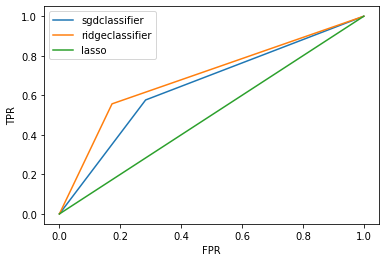

In [22]:
print('train dataset')
for model in models:
    y_pred_train = model.predict(X_train)
         
    print(model.get_params()['steps'][1][0])
    show_auc(y_train, y_pred_train, model.get_params()['steps'][1][0])

test dataset:
sgdclassifier
ROC AUC: 0.5926
ridgeclassifier
ROC AUC: 0.6360
lasso
ROC AUC: 0.5000


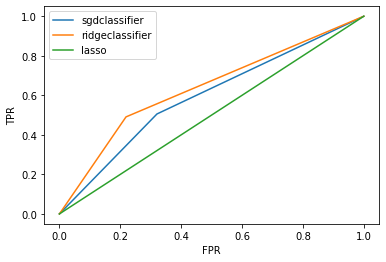

In [23]:
print('test dataset:')
for model in models:
    y_pred_test = model.predict(X_test)
         
    print(model.get_params()['steps'][1][0])
    show_auc(y_test, y_pred_test, model.get_params()['steps'][1][0])

Попробуем вывести 10 самых значимых признаков для каждой модели (а именно, для которых коэффициенты модели максимальны по модулю).

In [24]:
for model in models:
    print('\n' + model.get_params()['steps'][1][0])
    coef = model.named_steps[model.get_params()['steps'][1][0]].coef_
    # небольшой костыль, потому что coef_ для моделей sgd и ridge возвращает список в списке, а для lasso - обычный список
    if len(coef) == 1:
        my_list = model.named_steps[model.get_params()['steps'][1][0]].coef_[0]
    else:
        my_list = coef
    new_dict =  { list(X)[i] : my_list[i] for i in range(len(my_list)) }
    j = 0
    for key, value in sorted(new_dict.items(), key=lambda item: abs(item[1]), reverse=True):
        print(key, value)
        j += 1
        if (j == 10): 
            break


sgdclassifier
action_type_Jump Shot -0.7659381638478566
action_type_Driving Layup Shot 0.544004229239417
combined_shot_type_Dunk 0.5180569128643708
action_type_Slam Dunk Shot 0.495981554182324
action_type_Layup Shot -0.49113694813477915
action_type_Running Jump Shot 0.482971501495419
action_type_Driving Dunk Shot 0.329692520034815
shot_zone_area_Back Court(BC) -0.3196629188413998
shot_zone_range_Back Court Shot -0.3196629188413998
combined_shot_type_Jump Shot -0.29304478332764283

ridgeclassifier
action_type_Jump Shot -0.1643936753801683
action_type_Running Jump Shot 0.10328881819187302
action_type_Driving Layup Shot 0.0996747283552878
action_type_Layup Shot -0.09473305536925813
combined_shot_type_Dunk 0.08072097380107171
action_type_Pullup Jump shot 0.06918628241169743
action_type_Jump Bank Shot 0.06070461194399488
action_type_Slam Dunk Shot 0.06054389271569526
combined_shot_type_Jump Shot -0.053179168896516305
shot_zone_basic_Above the Break 3 -0.05205970759097822

lasso
lat 0.0
lon

Можем наблюдать, что разные модели назначили признакам различную важность. В чём-то, однако, они сошлись: так, например, максимальную значимость имеет признак action_type Jump Shot. <br>
**модель Lasso почему-то не работает как нужно, все коэффициенты по нулям...**
